## Sine Wave Prediction

### Visualizing a Sine Wave

In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_points = 100
n_points_per_cycle = 30
n_cycles = n_points // n_points_per_cycle

x = np.linspace(0, 2*n_cycles*np.pi, num=n_points)
y = np.sin(x) + np.random.randn(n_points) / 25 # add noise

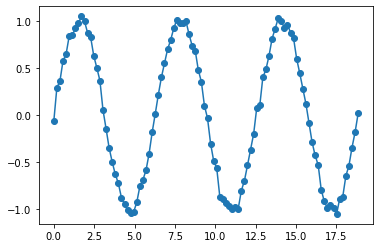

In [3]:
plt.plot(x, y, marker='o')

#### Project Formulation
- given "lookback" data points which form a sine wave, we try to predict the data point which is at a "delay" distance into the future
- No subsampling in this case, we consider all points

### Creating the Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class SinWaveDataset(Dataset):
    def __init__(self, n_data_points, n_points_per_cycle, lookback, delay):
        '''
        n_data_points: int - total number of data points
        n_points_per_cycle: int - number of points that should be present in one cycle i.e between 0 and 2*pi
        '''
        self.lookback = lookback
        self.delay = delay
        self.n_data_points = n_data_points
        
        n_cycles = n_data_points // n_points_per_cycle
        self.data = torch.linspace(0, 2*n_cycles*np.pi, n_data_points, dtype=torch.float32)
        self.data = torch.sin(self.data) + torch.randn(n_data_points) / 25 # add a little noise
        
    def __len__(self):
        return self.n_data_points - self.lookback - self.delay + 1
    
    def __getitem__(self, idx):
        assert idx < self.__len__()
        X = self.data[idx:idx + self.lookback]
        Y = self.data[idx + self.lookback + self.delay - 1]
        
        return X, Y

In [6]:
n_points_per_cycle = lookback = 30 # let's try with sequence length same as no. of points in a cycle
n_data_points = 1000
delay = 2

In [7]:
dataset = SinWaveDataset(n_data_points, n_points_per_cycle, lookback, delay)

In [8]:
idx = 5
x, y = dataset[idx]

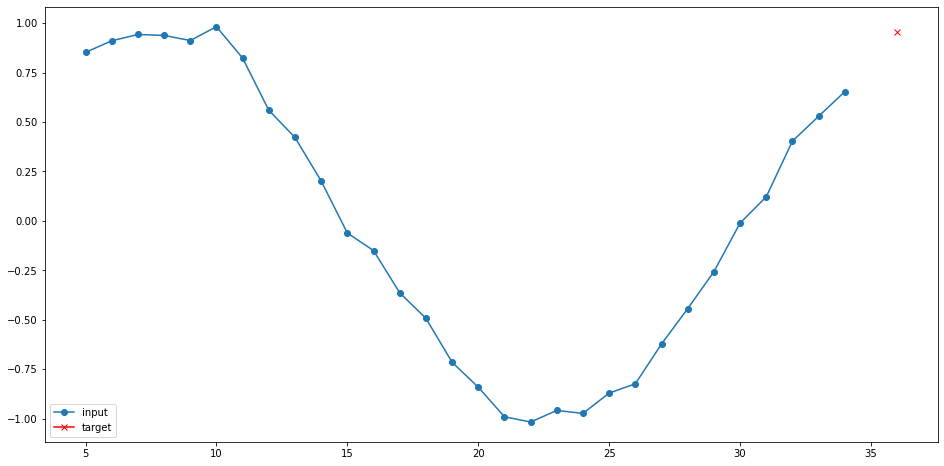

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(np.arange(idx, idx + lookback), x.detach().numpy(), marker='o', label="input")
ax.plot(idx + lookback + delay - 1, y.detach().numpy(), marker='x', color='red', label="target")

ax.legend(loc=3)

### Creating Datasets

In [10]:
train_dataset = SinWaveDataset(10000, n_points_per_cycle, lookback, delay)
test_dataset = SinWaveDataset(2000, n_points_per_cycle, lookback, delay)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
for x_test, y_test in test_dataloader:
    print(x_test.shape, y_test.shape)
    break

torch.Size([128, 30]) torch.Size([128])


#### Common-Sense Baseline
since the sine wave is periodic, and our sequence length is one cycle, the points will be repeating itself, hence points at a distance 'delay' from the beginning of the sequence is equal to points at a distance 'delay' from the end of the sequence

In [14]:
def mean_square_error(preds, targets):
    return torch.mean(torch.square(preds - targets))

In [22]:
total_loss = 0
n_batches = 0
for x_test, y_test in test_dataloader:
    preds = x_test[:, 2]
    loss_per_batch = mean_square_error(preds, y_test)
    
    total_loss += loss_per_batch
    n_batches += 1
    
print(f"loss: {total_loss / n_batches}")

loss: 0.03885425627231598


Loss is pretty low; it means our common sense baseline makes sense

### Building the Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class LSTMSineWavePredictor(nn.Module):
    def __init__(self, HIDDEN_SIZE):
        super().__init__()
        self.lstm = nn.LSTM(1, HIDDEN_SIZE)
        self.linear1 = nn.Linear(HIDDEN_SIZE, 64)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(64, 1)
        
    def forward(self, inputs):
        inputs = inputs.transpose(0, 1)
        lstm_out, (h, c) = self.lstm(inputs)
        out = F.relu(self.linear1(lstm_out[-1]))
        out = self.dropout(out)
        out = self.linear2(out)
        
        return out

In [15]:
HIDDEN_SIZE = 128

In [16]:
model = LSTMSineWavePredictor(HIDDEN_SIZE)

#### Testing Inference

In [17]:
x_test_ = x_test.unsqueeze(-1)
y_test_ = y_test.unsqueeze(-1)

out = model(x_test_)
assert out.shape == y_test_.shape

In [18]:
device = torch.device("cuda")

In [19]:
model.to(device=device)

LSTMSineWavePredictor(
  (lstm): LSTM(1, 128)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
import torch.optim as optim

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()
n_epochs = 20

### Training the Model

In [23]:
from tqdm import tqdm

In [24]:
train_loss_list = []
val_loss_list = []
for epoch in tqdm(range(n_epochs)):

    # train
    model.train()

    cummulative_loss = 0
    n_batches = 0
    for sequences, labels in train_dataloader:
        sequences = sequences.unsqueeze(-1)
        labels = labels.unsqueeze(-1)
        
        sequences = sequences.to(device=device)
        labels = labels.to(device=device)

        outputs = model(sequences)
        train_loss = loss(outputs, labels)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        cummulative_loss += train_loss
        n_batches += 1

    loss_per_epoch = cummulative_loss / n_batches
    train_loss_list.append(loss_per_epoch)

    # val
    model.eval()

    cummulative_loss_val = 0
    n_batches_val = 0
    for sequences, labels in test_dataloader:    
        sequences = sequences.unsqueeze(-1)
        labels = labels.unsqueeze(-1)
        
        sequences = sequences.to(device=device)
        labels = labels.to(device=device)

        with torch.no_grad():
            outputs = model(sequences)
            val_loss = loss(outputs, labels) 

        cummulative_loss_val += val_loss
        n_batches_val += 1

    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]


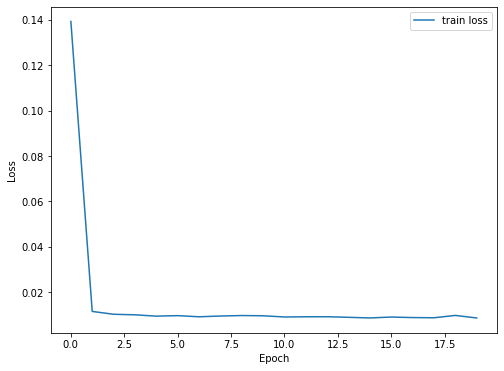

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

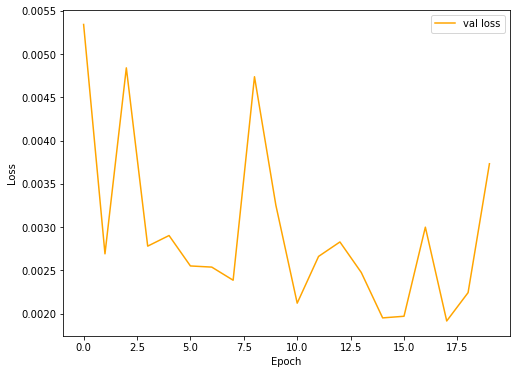

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

Looks like we have beat the common sense baseline

### Plotting Predictions

We didn't shuffle the test dataloader, so the predictions should look like a sine wave

In [31]:
# plotting only for a single batch
for x_test, y_test in test_dataloader:
    x_test = x_test.unsqueeze(-1)
    preds = model(x_test.cuda())
    break

In [34]:
preds = preds.view(-1)

In [39]:
preds = preds.cpu()
y_test = y_test.cpu()

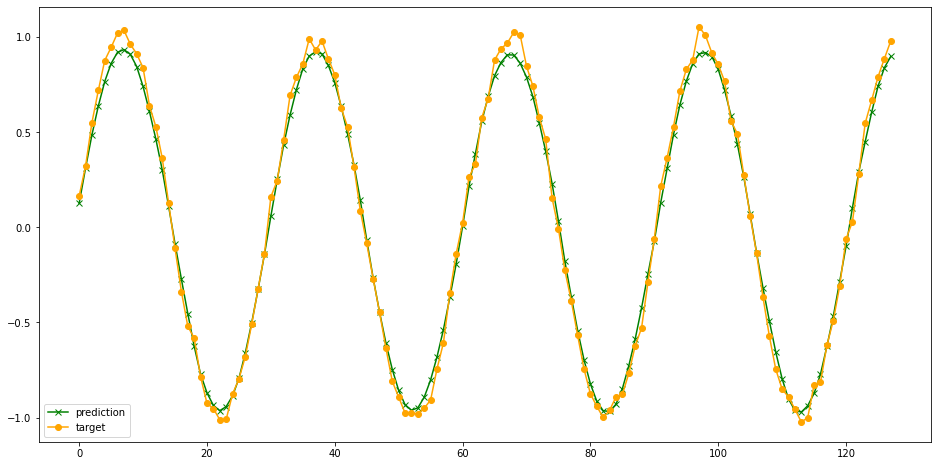

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8))

axes.plot(preds.detach().numpy(), color='green', label="prediction", marker='x')
axes.plot(y_test.detach().numpy(), color='orange', label="target", marker='o')

plt.legend()

##### Looking Wonderful